Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [33]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import  Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight
import tensorflow_datasets as tfds
import cv2
import glob

In [34]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

# from google.colab import drive
# drive.mount('/content/gdrive')


In [35]:
#!pip install google.colab

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [46]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset 
root_path = '/content/drive/MyDrive/CNN/MelanomaDetection/'
data_dir_train = pathlib.Path(root_path+"Train/")
data_dir_test = pathlib.Path(root_path+'Test/')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "training",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    validation_split = 0.2,
    subset = "validation",
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [49]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

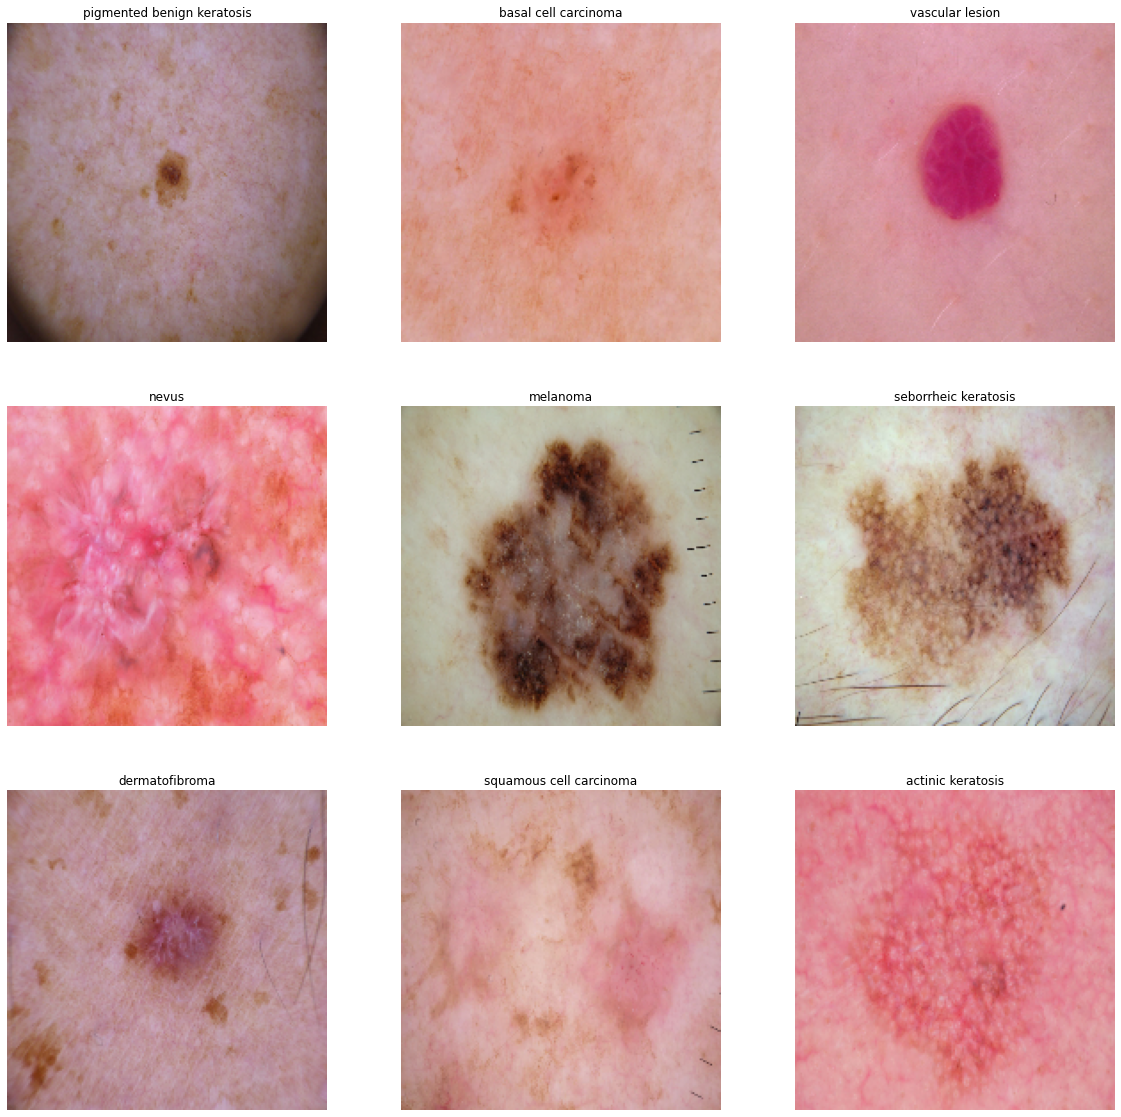

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
class_names = train_ds.class_names
num=0
used_labels = []
for images, labels in train_ds.take(3):
    for i in range(32):
        if (labels[i] not in used_labels):
            used_labels.append(labels[i])
            num=num+1
            ax = plt.subplot(3, 3, num)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
       


### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use 
```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 176, 176, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 88, 64)        18496     
                                                        

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  workers=10,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 514s 6s/step - loss: 2.2088 - accuracy: 0.1931 - val_loss: 2.0204 - val_accuracy: 0.1588
Epoch 2/20
56/56 [==============================] - 287s 5s/step - loss: 2.0434 - accuracy: 0.2316 - val_loss: 1.9890 - val_accuracy: 0.2349
Epoch 3/20
56/56 [==============================] - 290s 5s/step - loss: 1.8266 - accuracy: 0.3331 - val_loss: 1.6549 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 289s 5s/step - loss: 1.6083 - accuracy: 0.4180 - val_loss: 1.4776 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 291s 5s/step - loss: 1.4503 - accuracy: 0.4844 - val_loss: 1.4325 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 289s 5s/step - loss: 1.3528 - accuracy: 0.5368 - val_loss: 1.3737 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 331s 6s/step - loss: 1.3220 - accuracy: 0.5352 - val_loss: 1.4282 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing training results

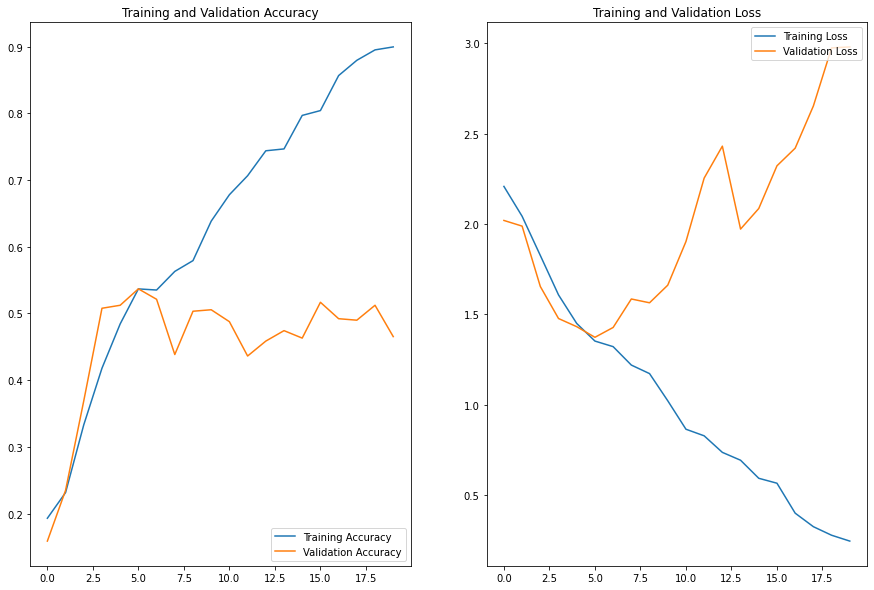

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

#### Clearly model is overfitting, validation loss is increasing with epochs and training loss is decreasing and large difference between accuracies

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit,
#choose an appropriate data augumentation strategy. 
# Your code goes here



train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range            = 90.0,
    zoom_range                = [0.9,1.1],
    horizontal_flip           = [0.9,1.1],
    vertical_flip             = True,
    height_shift_range        = 10.0,
    width_shift_range         = 10.0,
    shear_range               = 5.0,
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',     
    validation_split          =0.2                     
    )
                                  

# Train data
train_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='training',                  
                                                    target_size=(180, 180),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    )

# Validation data
test_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='validation',                 
                                                    target_size=(180, 180),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    )

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

x_batch, y_batch = next(train_generator)

for i in range (0,32):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()       

Output hidden; open in https://colab.research.google.com to view.

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))

model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.15))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
#model.add(Dropout(0.15))
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.15))
model2.add(Dense(9))
model2.add(Activation('softmax'))

### Todo, choose an appropirate optimiser and loss function



### Compiling the model

In [ ]:
## Your code goes here
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history2 = model2.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  workers=12
)


Epoch 1/20
57/57 [==============================] - 54s 824ms/step - loss: 2.0710 - accuracy: 0.2089 - val_loss: 2.0186 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 52s 824ms/step - loss: 2.0226 - accuracy: 0.1955 - val_loss: 2.0132 - val_accuracy: 0.2072
Epoch 3/20
57/57 [==============================] - 50s 786ms/step - loss: 2.0197 - accuracy: 0.1911 - val_loss: 2.0137 - val_accuracy: 0.2072
Epoch 4/20
57/57 [==============================] - 48s 726ms/step - loss: 2.0222 - accuracy: 0.2095 - val_loss: 2.0122 - val_accuracy: 0.2072
Epoch 5/20
57/57 [==============================] - 48s 745ms/step - loss: 2.0210 - accuracy: 0.1994 - val_loss: 2.0115 - val_accuracy: 0.2072
Epoch 6/20
57/57 [==============================] - 54s 728ms/step - loss: 2.0169 - accuracy: 0.1955 - val_loss: 2.0119 - val_accuracy: 0.1959
Epoch 7/20
57/57 [==============================] - 55s 953ms/step - loss: 2.0216 - accuracy: 0.1978 - val_loss: 2.0151 - val_accuracy: 0.2072

### Visualizing the results

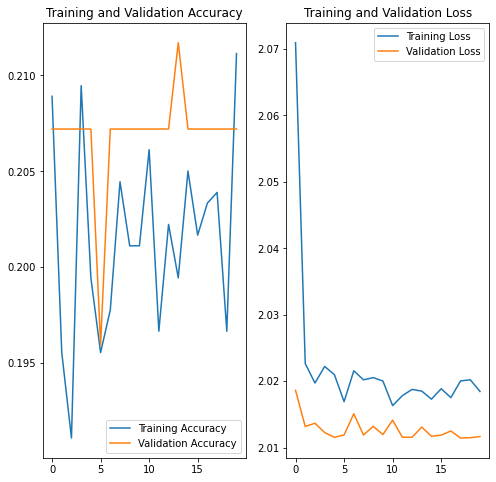

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Model is clearly underfitting, both training and validation accuracies are very low. No there is no improvement it has rather depritiated more.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
root_path = '/content/drive/MyDrive/CNN/MelanomaDetection/'
data_dir_train_check = pathlib.Path(root_path+"Train/")
train_ds_check = tf.keras.utils.image_dataset_from_directory(
    data_dir_train_check,
    #validation_split = 0,
  #  subset = "training",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

train_ds_check = train_ds_check.map(lambda x, y: (normalization_layer(x), category_layer(y)))

train_ds_np = tfds.as_numpy(train_ds_check)

Found 2239 files belonging to 9 classes.


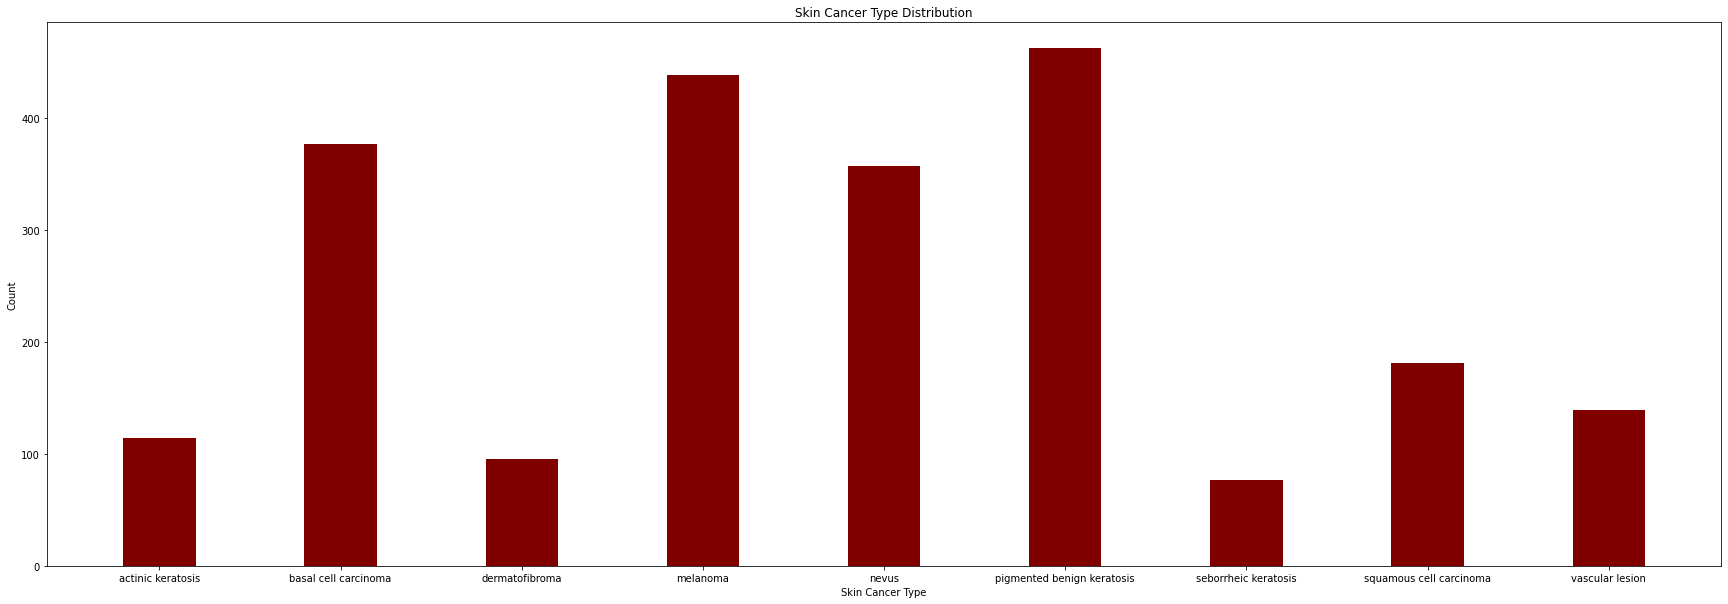

In [ ]:
distribution = []
class_dist = dict()
for features_labels in train_ds_np:
    for row in features_labels[1]:
        distribution.append(row)
       # print(distribution)

dist_df = pd.DataFrame(distribution)   
dist_df.columns = class_names

for cl in class_names:
    class_dist[cl] = dist_df[cl].sum()
    
keys = list(class_dist.keys())
values = list(class_dist.values())
  
fig = plt.figure(figsize = (30, 10))
 

plt.bar(keys, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Skin Cancer Type")
plt.ylabel("Count")
plt.title("Skin Cancer Type Distribution")
plt.show()


In [ ]:
class_dist

{'actinic keratosis': 114.0,
 'basal cell carcinoma': 376.0,
 'dermatofibroma': 95.0,
 'melanoma': 438.0,
 'nevus': 357.0,
 'pigmented benign keratosis': 462.0,
 'seborrheic keratosis': 77.0,
 'squamous cell carcinoma': 181.0,
 'vascular lesion': 139.0}

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/CNN/MelanomaDetection/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F85B3FDDA90>: 100%|██████████| 500/500 [00:19<00:00, 25.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F86F5533850>: 100%|██████████| 500/500 [00:17<00:00, 29.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85B3FDA810>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F85B3E45F10>: 100%|██████████| 500/500 [01:31<00:00,  5.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F85C1FC5D10>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85C1F931D0>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F85C1E2CB10>: 100%|██████████| 500/500 [00:40<00:00, 12.40 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85C2000A50>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/MelanomaDetection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85C1E279D0>: 100%|██████████| 500/500 [00:18<00:00, 26.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [50]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [52]:
path_list_original=[]
for cl in class_names:
    path_list = [x for x in glob.glob(os.path.join(data_dir_train,cl ,'*.jpg'))]
    path_list_original.extend(path_list)
#path_list_original

In [53]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)
#lesion_list_new

4500

In [54]:
lesion_list_original = []

for cl in class_names:
    lesion_list_org= [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train,cl,'*.jpg'))]
    lesion_list_original.extend(lesion_list_org)
  
#lesion_list_original



In [55]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [56]:
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))

In [57]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

In [58]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [59]:
len(new_df)
#new_df.groupby(by=['Label']).count()


6739

In [60]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [62]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train="/content/drive/MyDrive/CNN/MelanomaDetection/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [63]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [64]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))


#### **Todo:** Create your model (make sure to include normalization)

In [65]:
model3 = Sequential( 
    [layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

## simple model works better with more data

model3.add(Conv2D(16, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.20))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(9))
model3.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [66]:
## your code goes here
model3.compile(optimizer='adam', # 'SGD'
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [67]:
epochs = 30
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  workers=12
)

Epoch 1/30
169/169 [==============================] - 958s 5s/step - loss: 1.8714 - accuracy: 0.2891 - val_loss: 1.5546 - val_accuracy: 0.4328
Epoch 2/30
169/169 [==============================] - 32s 181ms/step - loss: 1.4598 - accuracy: 0.4466 - val_loss: 1.2798 - val_accuracy: 0.5434
Epoch 3/30
169/169 [==============================] - 31s 180ms/step - loss: 1.3449 - accuracy: 0.4833 - val_loss: 1.3138 - val_accuracy: 0.5160
Epoch 4/30
169/169 [==============================] - 37s 212ms/step - loss: 1.2215 - accuracy: 0.5458 - val_loss: 1.2028 - val_accuracy: 0.5650
Epoch 5/30
169/169 [==============================] - 36s 206ms/step - loss: 1.1497 - accuracy: 0.5681 - val_loss: 1.0849 - val_accuracy: 0.5805
Epoch 6/30
169/169 [==============================] - 32s 182ms/step - loss: 1.0601 - accuracy: 0.5918 - val_loss: 1.0311 - val_accuracy: 0.6244
Epoch 7/30
169/169 [==============================] - 32s 183ms/step - loss: 1.0247 - accuracy: 0.6113 - val_loss: 1.0679 - val_accu

#### **Todo:**  Visualize the model results

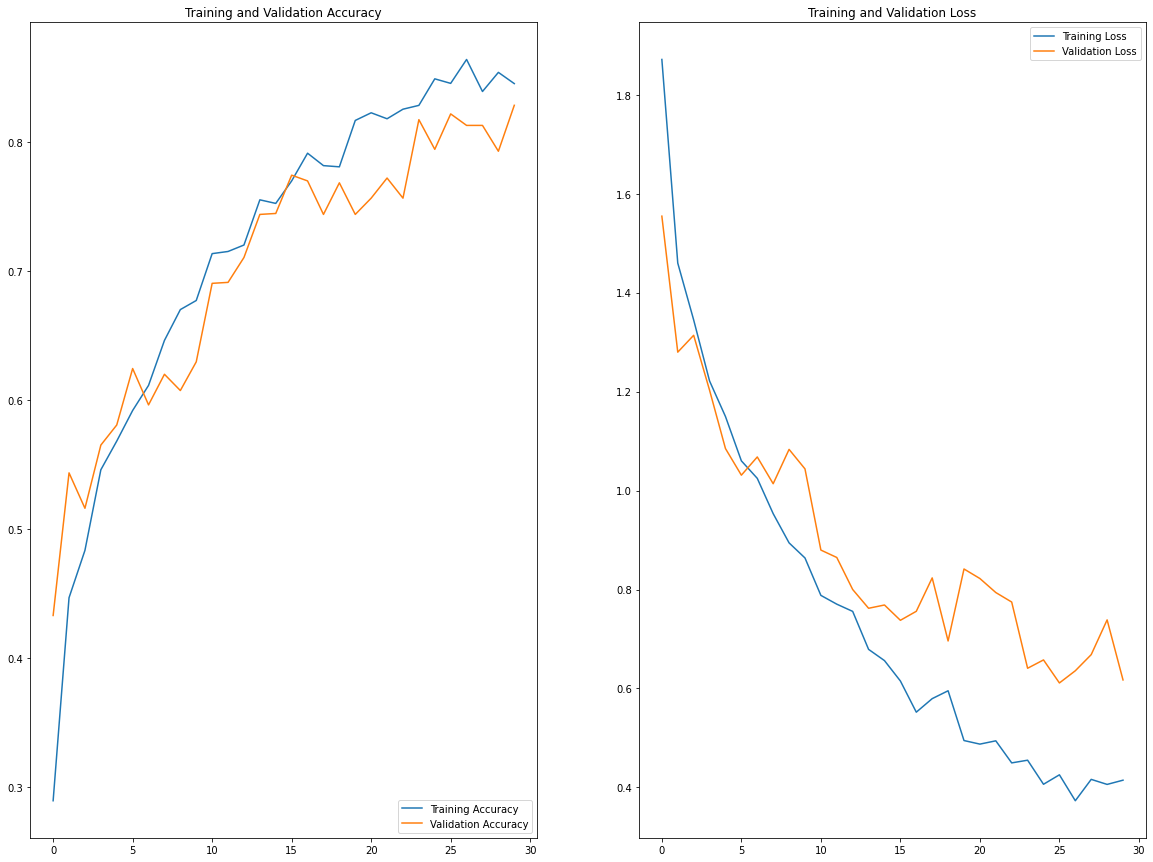

In [68]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Augmentation helped in removing overfitting and underfitting that occured in above models. Training and validation accuracies and losses are close to each



## Test Prediction

In [82]:
test_ds_orig = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=120,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 118 files belonging to 9 classes.


In [83]:
test_ds = test_ds_orig.map(lambda x, y: (normalization_layer(x), category_layer(y)))

In [84]:
y_pred = model3.predict(test_ds)

In [85]:
test_ds_np = tfds.as_numpy(test_ds_orig)
actual=[]

for features_labels in test_ds_np:
    for row in features_labels[1]:
        actual.append(row)

len(actual)


118

In [86]:
type(actual[1])

numpy.int32

In [87]:
pred_df = pd.DataFrame(y_pred)
pred_df["actual"] = actual
pred_df.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 'actual'], dtype='object')

In [88]:
# get prediction value as max probability class 
def get_result(row):
  row = row.tolist()
  max_value = -1
  index = -1
  for i in range(0,9):
    if row[i] > max_value:
      max_value = row[i]
      index = i
  if row[9]==index:
    return True
  else: 
    return False

In [89]:
pred_df["result"] = pred_df.apply(lambda row: get_result(row), axis = 1)

In [90]:
pred_df

,0,1,2,3,4,5,6,7,8,actual,result
0,4.472010e-04,9.743192e-01,1.907551e-02,0.000230,0.000054,0.002118,3.008932e-06,2.891061e-03,8.626019e-04,2,False
1,9.411334e-04,1.882400e-02,9.789903e-01,0.000017,0.000078,0.000372,2.267355e-06,7.757763e-04,1.203319e-09,6,False
2,5.010818e-01,1.120064e-01,8.124793e-05,0.000922,0.109444,0.203858,1.060686e-05,7.250290e-02,9.306650e-05,5,False
3,2.483119e-15,8.256173e-13,6.323355e-15,0.001006,0.998990,0.000004,1.048890e-10,3.996926e-21,3.564224e-23,0,False
4,1.109364e-01,8.008604e-04,1.478502e-14,0.000051,0.885167,0.003045,4.451611e-09,1.110767e-07,4.222090e-11,0,False
...,...,...,...,...,...,...,...,...,...,...,...
113,1.445942e-03,2.198154e-01,1.066319e-02,0.005850,0.004481,0.220623,4.058469e-03,5.309569e-01,2.106286e-03,1,False
114,7.493715e-01,3.208744e-03,3.434231e-04,0.105619,0.093755,0.033886,6.764497e-08,1.381663e-02,1.806613e-11,0,True
115,2.003565e-03,4.965458e-01,1.525725e-04,0.000006,0.000113,0.000917,1.083319e-07,5.002614e-01,4.183022e-07,7,True
116,6.912542e-03,4.114183e-02,3.199494e-05,0.457783,0.041677,0.046181,4.062054e-01,6.695904e-05,9.773579e-08,0,False
